# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
import sklearn
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,143424.0,1.674290e+08,1.019046e+08,12522.0,88295964.0,154763706.0,232089688.5,443867222.0
patient_nbr,143424.0,5.493608e+07,3.857840e+07,135.0,23572188.0,46307830.5,88236270.0,189502619.0
admission_type_id,143424.0,2.027694e+00,1.427585e+00,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,143424.0,3.655316e+00,5.219279e+00,1.0,1.0,1.0,3.0,28.0
admission_source_id,143424.0,5.701096e+00,4.064532e+00,1.0,1.0,7.0,7.0,25.0
time_in_hospital,143424.0,4.490190e+00,2.999667e+00,1.0,2.0,4.0,6.0,14.0
number_outpatient,143424.0,3.624289e-01,1.249295e+00,0.0,0.0,0.0,0.0,42.0
number_inpatient,143424.0,6.008548e-01,1.207934e+00,0.0,0.0,0.0,1.0,21.0
number_emergency,143424.0,1.950859e-01,9.204102e-01,0.0,0.0,0.0,0.0,76.0
num_lab_procedures,143424.0,4.325575e+01,1.965732e+01,1.0,32.0,44.0,57.0,132.0


In [6]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [7]:
d1 = pd.DataFrame({'Total lines(Records)': [df.shape[0]], 
                   'Unique Encounter Count' : [df['encounter_id'].nunique()],
                   'Unique Patient Count' : [df['patient_nbr'].nunique()]})

In [8]:
d1

,Total lines(Records),Unique Encounter Count,Unique Patient Count
0,143424,101766,71518


**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response: As we can see from above analysis , Total Records count(Lines Count) in the dataset is higher than unique encounter record counts and unique patient counts.  Therefore, dataset is at line level.  


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields. 

Response to point a :
1.  Only NDC column has null values.  There are 23462 NULL values for NDC code.
2.  Following columns : number_outpatient, number_inpatient,number_emergency, num_procedures have zero values.  This is 
    expected values since few patients may not have inpatient, outpatient or emergency visits in the past.

Response to point b :
1.  Based on SNS distribution plot (as shown in below analysis),  there are no data elements which has true gaussian
    distribution although "num_lab_procedures" follows somewhat gaussian distribution.

Response to point c :  
Below are top 3 categorical columns with highest cardinality.  It make sense that these fields have high cardanality since patients can multiple codes ( primary, principal, secondary,medication codes) for multiple encounters - as part of overall patient history.  Also, there are thousands of ICD10-CM and NDC codes exists in health care systems. 
1)  other_diagnosis_codes : 19374
2)  primary_diagnosis_code : 717
3)  ndc_code : 251

Response to point d :
1)  Age and Gender distribution is shown below.
2)  As we can see from Age distribution, Top 3 Age bins are : 70-80, 60-70 & 50-60.  
3)  Based on Gender distribution,  there are more female patients in this dataset as compared to Male patients.


In [9]:
# Find Null values, Zeros values and Cardanility for each columns in the dataframe (df)
d2 = pd.DataFrame(  {'Column Name':df.columns,
                    'Null Value Count': df.isnull().sum(),
                    'Null Value Count(%)': df.isnull().sum()*100/len(df),
                    'Zero Value Count': df.isin([0]).sum(),
                    'Zero Value Count(%)': df.isin([0]).sum()*100/len(df),
                    'Cardinality' : df.nunique()
                  })

In [10]:
d2

,Column Name,Null Value Count,Null Value Count(%),Zero Value Count,Zero Value Count(%),Cardinality
encounter_id,encounter_id,0,0.00000,0,0.000000,101766
patient_nbr,patient_nbr,0,0.00000,0,0.000000,71518
race,race,0,0.00000,0,0.000000,6
gender,gender,0,0.00000,0,0.000000,3
age,age,0,0.00000,0,0.000000,10
weight,weight,0,0.00000,0,0.000000,10
admission_type_id,admission_type_id,0,0.00000,0,0.000000,8
discharge_disposition_id,discharge_disposition_id,0,0.00000,0,0.000000,26
admission_source_id,admission_source_id,0,0.00000,0,0.000000,17
time_in_hospital,time_in_hospital,0,0.00000,0,0.000000,14


In [11]:
# Identify Numeric columns in the dataframe(df)
Numeric_Columns = df.select_dtypes(include=["float", 'int']).columns
Categorical_Columns = df.select_dtypes(exclude=["float", 'int']).columns

In [12]:
# List of numeric columns in the dataframe(df)
Numeric_Columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures'],
      dtype='object')

In [13]:
# List of categorical columns in the dataframe(df)
Categorical_Columns

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

encounter_id - Distribution Plot


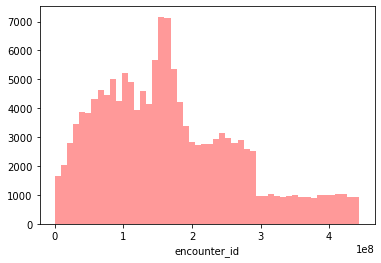

patient_nbr - Distribution Plot


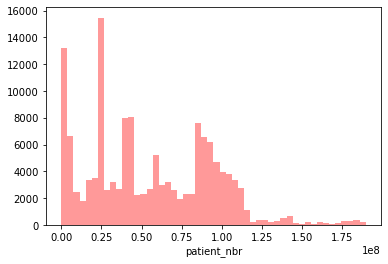

admission_type_id - Distribution Plot


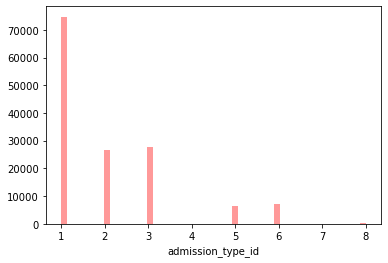

discharge_disposition_id - Distribution Plot


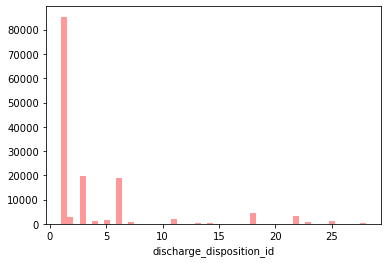

admission_source_id - Distribution Plot


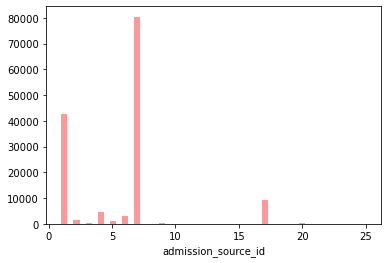

time_in_hospital - Distribution Plot


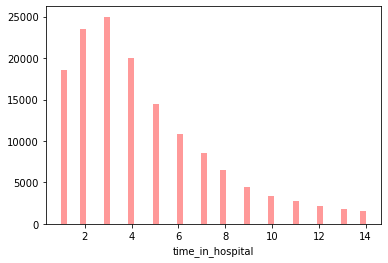

number_outpatient - Distribution Plot


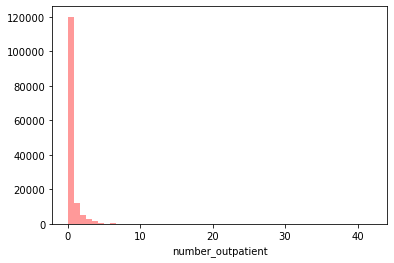

number_inpatient - Distribution Plot


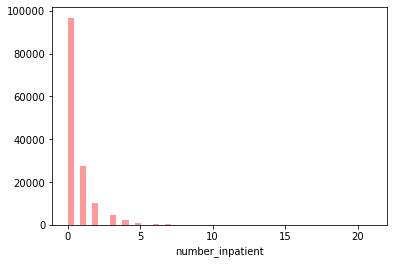

number_emergency - Distribution Plot


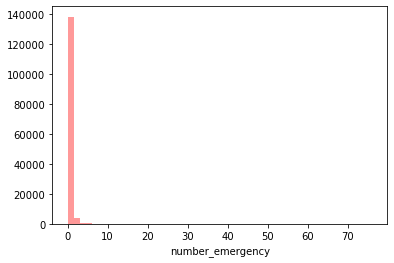

num_lab_procedures - Distribution Plot


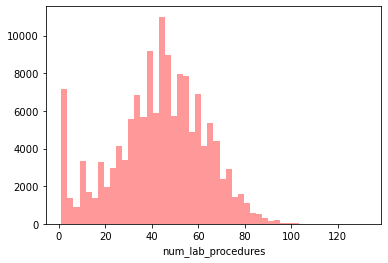

number_diagnoses - Distribution Plot


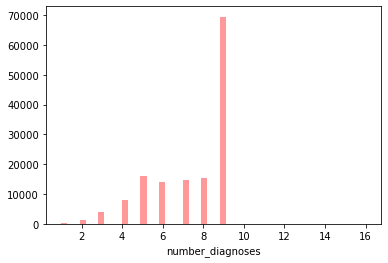

num_medications - Distribution Plot


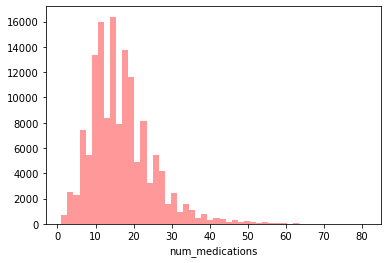

num_procedures - Distribution Plot


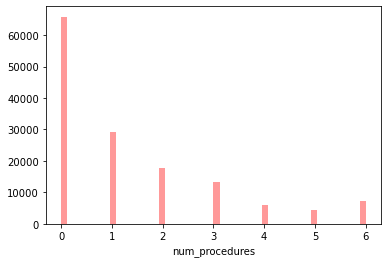

In [14]:
# Build distribution plot for all numeric columns in the dataframe using SNS Distplot. 
for columns in Numeric_Columns:
    sns.distplot(df[columns],kde=False,color='red')
    plt.title(print('{} - Distribution Plot'.format(columns)))
    plt.show()


Text(0.5, 1.0, 'Patient Age Distribution')

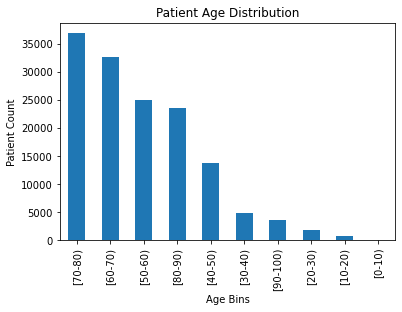

In [15]:
# Age distribution.
df['age'].value_counts().plot(kind='bar')
plt.xlabel('Age Bins')
plt.ylabel('Patient Count')
plt.title('Patient Age Distribution')

Text(0.5, 1.0, 'Patient Gender Distribution')

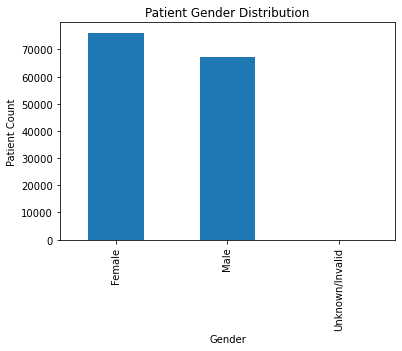

In [16]:
# Gender distribution 
df['gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Patient Count')
plt.title('Patient Gender Distribution')

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [ ]:
######NOTE: The visualization will only display in Chrome browser. ########
full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [17]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [18]:
from student_utils import reduce_dimension_ndc

In [19]:
reduce_dim_df = reduce_dimension_ndc(df,ndc_code_df)

In [20]:
reduce_dim_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R
1,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Novolin R
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,Novolin R
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
4,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120015,233607492,41369121,Caucasian,Female,[60-70),?,1,1,7,2,SP,?,250.8,110|786,0,2,0,38,4,7,0,64764-302,None,None,Ch,>30,Duetact
120016,254292852,100438128,Caucasian,Male,[60-70),?,2,6,7,7,MC,Emergency/Trauma,38,276|707,1,0,0,76,9,19,2,0781-5635,None,None,Ch,NO,Pioglitazone Hydrochloride And Glimepiride
120017,254292852,100438128,Caucasian,Male,[60-70),?,2,6,7,7,MC,Emergency/Trauma,38,276|707,1,0,0,76,9,19,2,0781-5635,None,None,Ch,NO,Pioglitazone Hydrochloride And Glimepiride
120018,403720562,41348115,Caucasian,Female,[60-70),?,3,3,1,6,CP,Radiologist,715,250|272,0,0,0,23,4,20,1,33342-177,None,None,Ch,NO,Pioglitazole And Metformin Hydrochloride


In [21]:
# Rename column 'Proprietary Name' to 'generic_drug_name'
#reduce_dim_df.rename(columns = {'Proprietary Name':'generic_drug_name'},inplace=True)

In [22]:
#reduce_dim_df

In [23]:
# Number of unique values should be less for the new output field
(df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique())

True

In [24]:
# Display NDC Codes vs Generic Drug Mapping  
print(reduce_dim_df[['ndc_code','generic_drug_name']])

          ndc_code                           generic_drug_name
0       68071-1701                                   Novolin R
1       68071-1701                                   Novolin R
2       68071-1701                                   Novolin R
3       68071-1701                                   Novolin R
4       68071-1701                                   Novolin R
...            ...                                         ...
120015   64764-302                                     Duetact
120016   0781-5635  Pioglitazone Hydrochloride And Glimepiride
120017   0781-5635  Pioglitazone Hydrochloride And Glimepiride
120018   33342-177    Pioglitazole And Metformin Hydrochloride
120019   43063-699                                 Glimepiride

[120020 rows x 2 columns]


In [25]:
reduce_dim_df['generic_drug_name'].nunique()

36

Text(0.5, 1.0, 'Generic Drug Name - Distribution ')

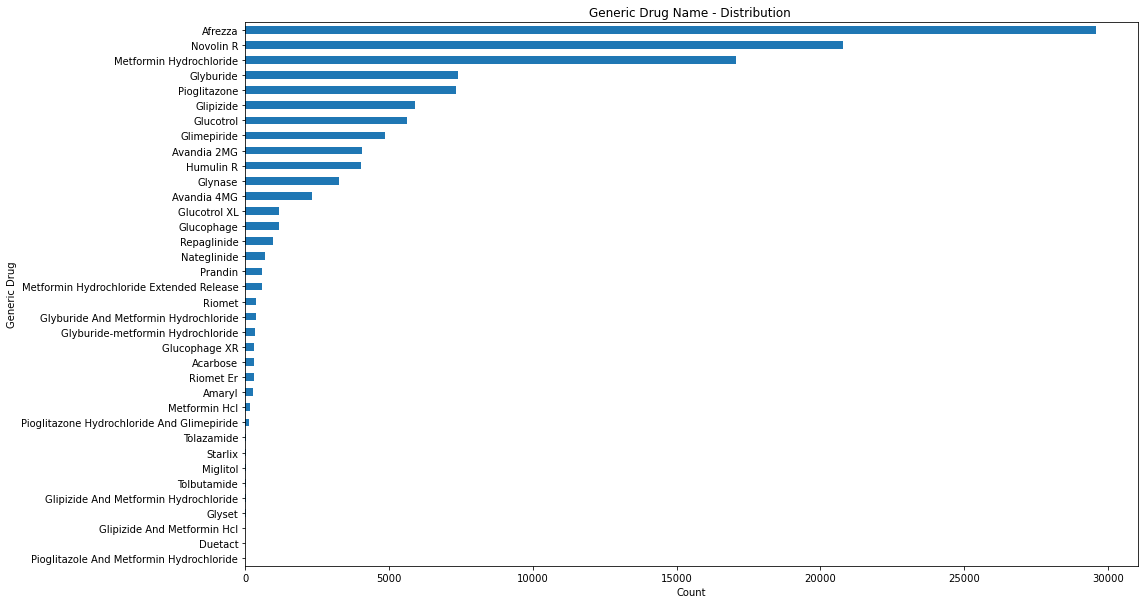

In [26]:
# Plot Generic Drug Name from the dataset
plt.figure(figsize =(16,10))
reduce_dim_df['generic_drug_name'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Generic Drug')
plt.title('Generic Drug Name - Distribution ')

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

Responses >>>
1.  Using below mentioned function ,  we have selected first encounters for each patient.
2.  To ensure there is no data leakage , Ran a test as well and printed output.  
3.  There are 56133 patients and 56133 encounters in the dataset now.  So, test is successful and there is no data leakage.

In [27]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [28]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


In [29]:
first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
22979,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,Glucotrol
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
22978,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glucotrol
4,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R
26409,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Afrezza


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [30]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [31]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [32]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,[Glucotrol],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,[Glucotrol],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: 
1. As we can see from below analysis (value counts analysis for weight and Payer code),  54127 Patients (out of 56133 total patients) have null values for their weights.  This means that most of the Patient records do not have their weight information. So, it will not be impact our model if we exclude it from our feature list.  Therefore, we can make decision to exclude weight from feature columns list. 

2. Payer code  -  There are 23319 patient records with no payer code information. Payer code is for health insurance company. Since its a categorical variable with payer information, it will not make sense to impute null payer code with any specific payer code name ( where there is null value).  Also, Payer code information does not have much impact on patient selection for drug testing . Therefore, we will exclude it from feature selection list.

In [33]:
agg_drug_df['weight'].value_counts()

?            54127
[75-100)       840
[50-75)        542
[100-125)      392
[125-150)      104
[25-50)         58
[0-25)          36
[150-175)       23
[175-200)        8
>200             3
Name: weight, dtype: int64

In [34]:
agg_drug_df['payer_code'].value_counts()

?     23319
MC    16626
HM     3093
SP     2819
BC     2684
MD     1860
CP     1558
UN     1522
CM     1120
OG      562
PO      372
DM      305
WC       98
CH       90
OT       50
SI       28
MP       26
FR        1
Name: payer_code, dtype: int64

In [35]:
ndc_col_list

['Acarbose',
 'Afrezza',
 'Amaryl',
 'Avandia_2MG',
 'Avandia_4MG',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glucophage',
 'Glucophage_XR',
 'Glucotrol',
 'Glucotrol_XL',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Glynase',
 'Glyset',
 'Humulin_R',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Metformin_Hydrochloride_Extended_Release',
 'Miglitol',
 'Nateglinide',
 'Novolin_R',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Prandin',
 'Repaglinide',
 'Riomet',
 'Riomet_Er',
 'Starlix',
 'Tolazamide',
 'Tolbutamide']

In [36]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''

# required_demo_col_list = ['race', 'gender', 'age']
# student_categorical_col_list = [ "feature_A", "feature_B", .... ] + required_demo_col_list + ndc_col_list
# student_numerical_col_list = [ "feature_A", "feature_B", .... ]
# PREDICTOR_FIELD = ''

required_demo_col_list = ['race', 'gender', 'age']

student_categorical_col_list = [ "ndc_code", "readmitted", 'admission_type_id', 'discharge_disposition_id',
                                'max_glu_serum', 'admission_source_id', 'A1Cresult', 'primary_diagnosis_code',
                                'other_diagnosis_codes', 'change'] + required_demo_col_list + ndc_col_list

student_numerical_col_list = [ "num_procedures", "num_medications", 'number_diagnoses']

PREDICTOR_FIELD = 'time_in_hospital'


In [37]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [38]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

Feature Columns 

In [39]:
selected_features_df

,patient_nbr,time_in_hospital,ndc_code,readmitted,admission_type_id,discharge_disposition_id,max_glu_serum,admission_source_id,A1Cresult,primary_diagnosis_code,other_diagnosis_codes,change,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide,num_procedures,num_medications,number_diagnoses
0,48330783,13,0049-4110,NO,2,1,None,4,None,398,427|38,Ch,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,28,8
1,63555939,12,68071-1701,NO,3,3,None,4,None,434,198|486,Ch,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,18,8
2,42519267,1,0049-4110,NO,1,1,None,7,None,197,157|250,Ch,Caucasian,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,5
3,89869032,9,68071-1701,>30,1,1,None,7,None,250.7,403|996,No,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,17,9
4,82637451,3,47918-902,>30,2,1,None,2,None,414,411|250,No,Caucasian,Male,[50-60),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,16,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56128,183087545,9,47918-902,>30,1,1,None,7,>7,574,574|250.02,Ch,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,33,9
56129,188574944,14,0049-0178,>30,1,1,None,7,>8,592,599|518,Ch,Other,Female,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,26,9
56130,140199494,2,47918-902,>30,1,1,None,7,None,996,585|403,No,Other,Female,[60-70),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,17,9
56131,181593374,5,68071-1701,NO,1,1,None,7,None,491,518|511,No,Caucasian,Female,[70-80),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,16,9


In [40]:
# Feature column list 
selected_features_df.columns

Index(['patient_nbr', 'time_in_hospital', 'ndc_code', 'readmitted',
       'admission_type_id', 'discharge_disposition_id', 'max_glu_serum',
       'admission_source_id', 'A1Cresult', 'primary_diagnosis_code',
       'other_diagnosis_codes', 'change', 'race', 'gender', 'age', 'Acarbose',
       'Afrezza', 'Amaryl', 'Avandia_2MG', 'Avandia_4MG', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glucophage', 'Glucophage_XR',
       'Glucotrol', 'Glucotrol_XL', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Glynase', 'Glyset', 'Humulin_R',
       'Metformin_Hcl', 'Metformin_Hydrochloride',
       'Metformin_Hydrochloride_Extended_Release', 'Miglitol', 'Nateglinide',
       'Novolin_R', 'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
       'Pioglitazone_Hydrochloride_And_Glimepiride', 'Prandin', 'Repaglinide',
       'Riomet', 'Riomet_Er', 'Starlix', 'Tol

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [41]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

Student Response >>  Please see below for responses.  Here is overall test results:

******Overall Training, Validation and Test Datasets Record Counts - Break Down************
             
Total number of records in Original dataset :   56133
Total number of records in Training dataset :   33680
Total number of records in Validation dataset : 11226
Total number of records in Test dataset :       11227
          
Training Dataset   split % :                    60.00
Validation Dataset split % :                    20.00
Validation Dataset split % :                    20.00

In [42]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [43]:
print( '******Overall Training, Validation and Test Datasets Record Counts - Break Down************')
print('             ')
print(f'Total number of records in Original dataset :   {len(processed_df)}')
print(f'Total number of records in Training dataset :   {len(d_train)}')
print(f'Total number of records in Validation dataset : {len(d_val)}')
print(f'Total number of records in Test dataset :       {len(d_test)}')
print('          ')
print(f'Training Dataset   split % :                    {((len(d_train)*100)/(len(processed_df))):.2f}')
print(f'Validation Dataset split % :                    {((len(d_val)*100)/(len(processed_df))):.2f}')
print(f'Validation Dataset split % :                    {((len(d_test)*100)/(len(processed_df))):.2f}')

******Overall Training, Validation and Test Datasets Record Counts - Break Down************
             
Total number of records in Original dataset :   56133
Total number of records in Training dataset :   33680
Total number of records in Validation dataset : 11226
Total number of records in Test dataset :       11227
          
Training Dataset   split % :                    60.00
Validation Dataset split % :                    20.00
Validation Dataset split % :                    20.00


In [44]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed : Total Number of rows in the orginal dataset = Train Record Count + Validation Record Count + Test Record Count")

Test passed : Total Number of rows in the orginal dataset = Train Record Count + Validation Record Count + Test Record Count


In [45]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()

print(f"Total Unique Patient Record Count in Training Dataset  : {d_train['patient_nbr'].nunique()}")
print(f"Total Unique Patient Record Count in Validation Dataset : {d_val['patient_nbr'].nunique()}")
print(f"Total Unique Patient Record Count in Test Dataset       : {d_test['patient_nbr'].nunique()}")
print(f"Total Unique Patient Record Count in Original Dataset   : {processed_df['patient_nbr'].nunique()}")
print ('       ')   
print("Test passed for number of unique patients being equal!")

Total Unique Patient Record Count in Training Dataset  : 33680
Total Unique Patient Record Count in Validation Dataset : 11226
Total Unique Patient Record Count in Test Dataset       : 11227
Total Unique Patient Record Count in Original Dataset   : 56133
       
Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

Respone >>> 
Based on below visuals, Label field (PREDICTOR Field) :'Time in Hospital' distribution for Original,Training,Validation and Test datasets look similar.

time_in_hospital
1.0      7532
2.0      9473
3.0     10028
4.0      7681
5.0      5566
6.0      4122
7.0      3231
8.0      2419
9.0      1655
10.0     1292
11.0     1054
12.0      807
13.0      702
14.0      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Time in Hospital - Distribution - for Original Dataset')

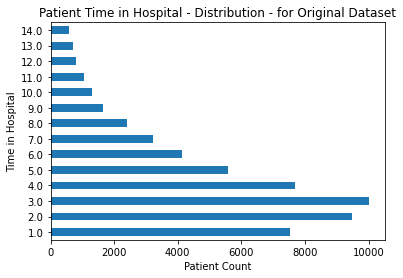

In [46]:
# Patient Time in Hospital - Distribution - for Original Dataset
show_group_stats_viz(processed_df, PREDICTOR_FIELD)
plt.xlabel('Patient Count')
plt.ylabel('Time in Hospital')
plt.title('Patient Time in Hospital - Distribution - for Original Dataset')

time_in_hospital
1.0     4526
2.0     5735
3.0     6110
4.0     4602
5.0     3318
6.0     2429
7.0     1934
8.0     1427
9.0      959
10.0     763
11.0     641
12.0     502
13.0     408
14.0     326
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Time in Hospital - Distribution - for Training Dataset')

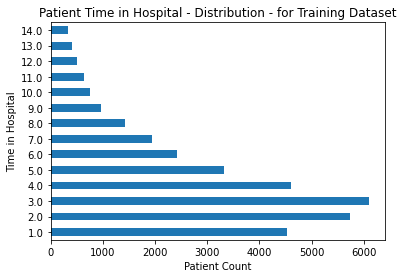

In [47]:
# Patient Time in Hospital - Distribution - for Training Dataset
show_group_stats_viz(d_train, PREDICTOR_FIELD)
plt.xlabel('Patient Count')
plt.ylabel('Time in Hospital')
plt.title('Patient Time in Hospital - Distribution - for Training Dataset')

time_in_hospital
1.0     1497
2.0     1902
3.0     1926
4.0     1517
5.0     1130
6.0      856
7.0      655
8.0      493
9.0      354
10.0     255
11.0     210
12.0     158
13.0     156
14.0     118
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Time in Hospital - Distribution - for Test Dataset')

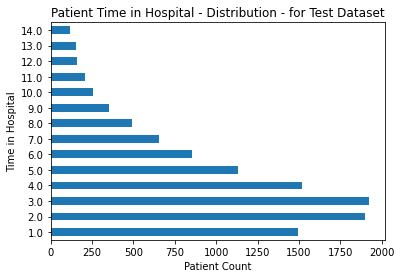

In [48]:
# Patient Time in Hospital - Distribution - for Test Dataset'
show_group_stats_viz(d_test, PREDICTOR_FIELD)
plt.xlabel('Patient Count')
plt.ylabel('Time in Hospital')
plt.title('Patient Time in Hospital - Distribution - for Test Dataset')

time_in_hospital
1.0     1509
2.0     1836
3.0     1992
4.0     1562
5.0     1118
6.0      837
7.0      642
8.0      499
9.0      342
10.0     274
11.0     203
12.0     147
13.0     138
14.0     127
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Time in Hospital - Distribution - for Validation Dataset')

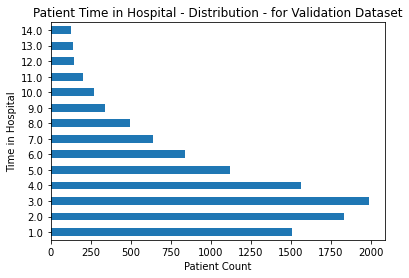

In [49]:
# Patient Time in Hospital - Distribution - for Validation Dataset'
show_group_stats_viz(d_val, PREDICTOR_FIELD)
plt.xlabel('Patient Count')
plt.ylabel('Time in Hospital')
plt.title('Patient Time in Hospital - Distribution - for Validation Dataset')

race
?                   1593
AfricanAmerican    10292
Asian                370
Caucasian          41766
Hispanic            1168
Other                944
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Original Dataset')

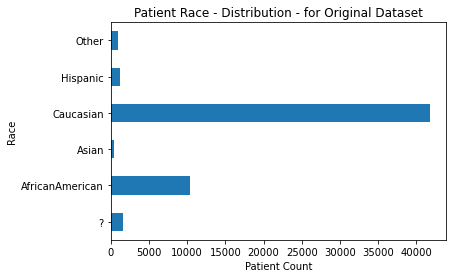

In [50]:
# Patient Race - Distribution - for Original Dataset
show_group_stats_viz(processed_df, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Original Dataset')

race
?                    965
AfricanAmerican     6242
Asian                222
Caucasian          25021
Hispanic             675
Other                555
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Training Dataset')

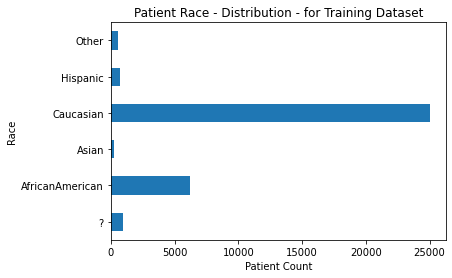

In [51]:
# Patient Race - Distribution - for Training Dataset
show_group_stats_viz(d_train, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Training Dataset')

race
?                   307
AfricanAmerican    2037
Asian                76
Caucasian          8325
Hispanic            276
Other               205
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Validation Dataset')

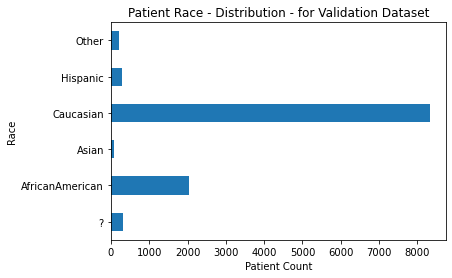

In [52]:
# Patient Race - Distribution - for Validation Dataset
show_group_stats_viz(d_val, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Validation Dataset')

race
?                   321
AfricanAmerican    2013
Asian                72
Caucasian          8420
Hispanic            217
Other               184
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Test Dataset')

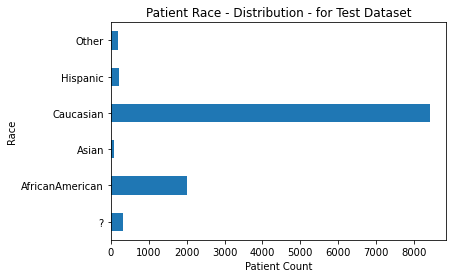

In [53]:
# Patient Race - Distribution - for Test Dataset
show_group_stats_viz(d_test, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Test Dataset')

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

Response >>
a. Gender distribution looks similar across Orginal, Training, Validation and Test datasets.
b. Race distribution looks similar across Orginal, Training, Validation and Test datasets.
c. Age distribution looks similar across Orginal, Training, Validation and Test datasets. 

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Gender - Distribution - for Original Dataset')

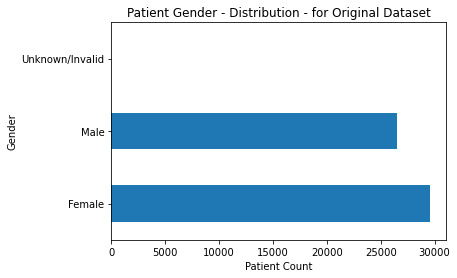

In [54]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')
plt.xlabel('Patient Count')
plt.ylabel('Gender')
plt.title('Patient Gender - Distribution - for Original Dataset')

gender
Female             17705
Male               15974
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Gender - Distribution - for Training Dataset')

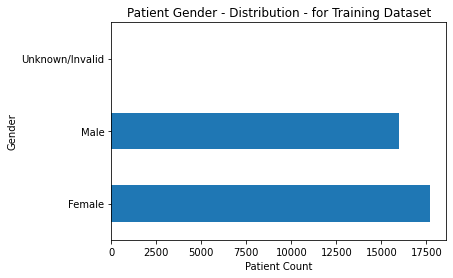

In [55]:
show_group_stats_viz(d_train, 'gender')
plt.xlabel('Patient Count')
plt.ylabel('Gender')
plt.title('Patient Gender - Distribution - for Training Dataset')

gender
Female    5945
Male      5282
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Gender - Distribution - for Test Dataset')

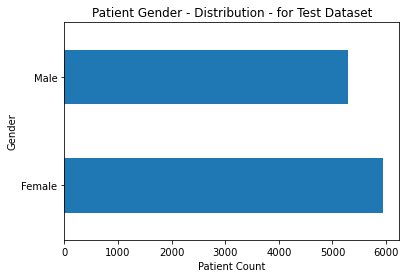

In [56]:
show_group_stats_viz(d_test, 'gender')
plt.xlabel('Patient Count')
plt.ylabel('Gender')
plt.title('Patient Gender - Distribution - for Test Dataset')


gender
Female             5933
Male               5292
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Gender - Distribution - for Validation Dataset')

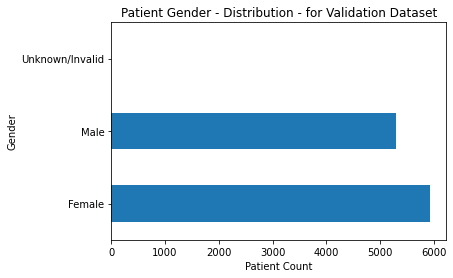

In [57]:
show_group_stats_viz(d_val, 'gender')
plt.xlabel('Patient Count')
plt.ylabel('Gender')
plt.title('Patient Gender - Distribution - for Validation Dataset')

race
?                   1593
AfricanAmerican    10292
Asian                370
Caucasian          41766
Hispanic            1168
Other                944
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Original Dataset')

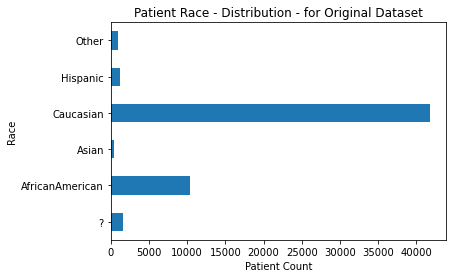

In [58]:
# Patient Race - Distribution - for Original Dataset
show_group_stats_viz(processed_df, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Original Dataset')

race
?                    965
AfricanAmerican     6242
Asian                222
Caucasian          25021
Hispanic             675
Other                555
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Training Dataset')

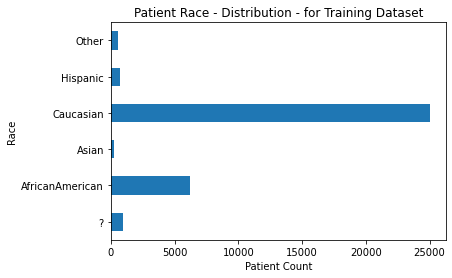

In [59]:
# Patient Race - Distribution - for Training Dataset
show_group_stats_viz(d_train, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Training Dataset')

race
?                   307
AfricanAmerican    2037
Asian                76
Caucasian          8325
Hispanic            276
Other               205
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Validation Dataset')

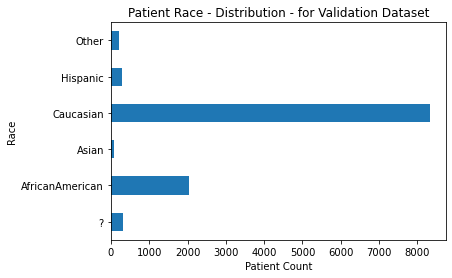

In [60]:
# Patient Race - Distribution - for Validation Dataset
show_group_stats_viz(d_val, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Validation Dataset')

race
?                   321
AfricanAmerican    2013
Asian                72
Caucasian          8420
Hispanic            217
Other               184
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Race - Distribution - for Test Dataset')

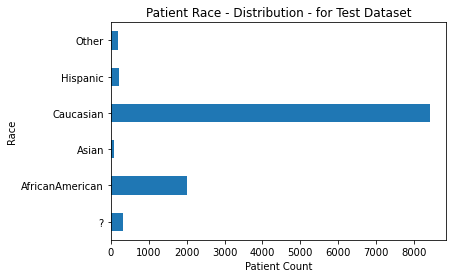

In [61]:
# Patient Race - Distribution - for Test Dataset
show_group_stats_viz(d_test, 'race')
plt.xlabel('Patient Count')
plt.ylabel('Race')
plt.title('Patient Race - Distribution - for Test Dataset')

age
[0-10)        130
[10-20)       466
[20-30)       890
[30-40)      2035
[40-50)      5368
[50-60)      9869
[60-70)     12776
[70-80)     14392
[80-90)      8848
[90-100)     1359
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Age - Distribution - for Original Dataset')

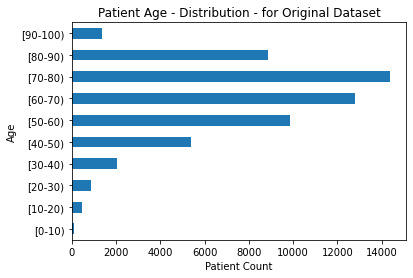

In [62]:
# Patient Race - Distribution - for Original Dataset
show_group_stats_viz(processed_df, 'age')
plt.xlabel('Patient Count')
plt.ylabel('Age')
plt.title('Patient Age - Distribution - for Original Dataset')

age
[0-10)        71
[10-20)      288
[20-30)      517
[30-40)     1206
[40-50)     3209
[50-60)     5993
[60-70)     7559
[70-80)     8742
[80-90)     5284
[90-100)     811
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Age - Distribution - for Training Dataset')

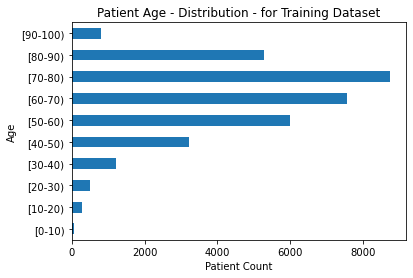

In [63]:
# Patient Race - Distribution - for Training Dataset
show_group_stats_viz(d_train, 'age')
plt.xlabel('Patient Count')
plt.ylabel('Age')
plt.title('Patient Age - Distribution - for Training Dataset')

age
[0-10)        28
[10-20)       89
[20-30)      185
[30-40)      432
[40-50)     1060
[50-60)     1903
[60-70)     2645
[70-80)     2845
[80-90)     1767
[90-100)     272
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Age - Distribution - for Validation Dataset')

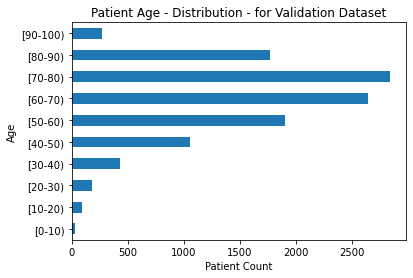

In [64]:
# Patient Race - Distribution - for Validation Dataset
show_group_stats_viz(d_val, 'age')
plt.xlabel('Patient Count')
plt.ylabel('Age')
plt.title('Patient Age - Distribution - for Validation Dataset')

age
[0-10)        31
[10-20)       89
[20-30)      188
[30-40)      397
[40-50)     1099
[50-60)     1973
[60-70)     2572
[70-80)     2805
[80-90)     1797
[90-100)     276
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Patient Age - Distribution - for Test Dataset')

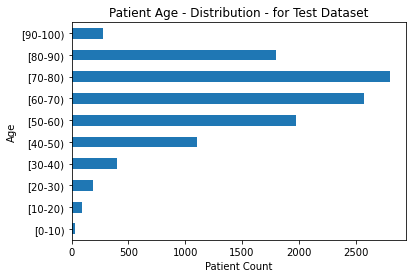

In [65]:
# Patient Race - Distribution - for Test Dataset
show_group_stats_viz(d_test, 'age')
plt.xlabel('Patient Count')
plt.ylabel('Age')
plt.title('Patient Age - Distribution - for Test Dataset')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [66]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [67]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [68]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [69]:
vocab_file_list

['./diabetes_vocab/ndc_code_vocab.txt',
 './diabetes_vocab/readmitted_vocab.txt',
 './diabetes_vocab/admission_type_id_vocab.txt',
 './diabetes_vocab/discharge_disposition_id_vocab.txt',
 './diabetes_vocab/max_glu_serum_vocab.txt',
 './diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/A1Cresult_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/other_diagnosis_codes_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Afrezza_vocab.txt',
 './diabetes_vocab/Amaryl_vocab.txt',
 './diabetes_vocab/Avandia_2MG_vocab.txt',
 './diabetes_vocab/Avandia_4MG_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './dia

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [70]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 237 in ndc_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/ndc_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.
INFO:tensorflow:vocabulary_size = 17 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabu

In [71]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='ndc_code', vocabulary_file='./diabetes_vocab/ndc_code_vocab.txt', vocabulary_size=237, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 238), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

Response >>  Numerical features are created using TF Feature columns as shown below.

In [72]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [73]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [74]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [75]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f13df3795f0>, mean=1.4268408551068883, std=1.7734087649032282))

tf.Tensor(
[[ 0.]
 [-1.]
 [ 5.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 3.]
 [ 2.]
 [ 0.]
 [-1.]
 [-1.]
 [ 3.]
 [-1.]
 [ 5.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 5.]
 [ 1.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 2.]
 [-1.]
 [ 0.]
 [ 2.]
 [ 2.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 1.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 5.]
 [ 0.]
 [-1.]
 [-1.]
 [ 3.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [ 5.]
 [-1.]
 [ 1.]
 [ 2.]
 [ 2.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 4.]
 [-1.]
 [ 5.]
 [ 0.]
 [-1.]
 [ 1.]
 [-1.]
 [ 2.]
 [-1.]
 [-1.]
 [ 5.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [ 5.]
 [ 1.]
 [ 0.]
 [ 3.]
 [ 3.]
 [-1.]
 [ 5.]
 [ 0.]
 [-1.]
 [-1.]
 [ 2.]
 [ 0.]
 [-1.]
 [ 1.]
 [-1.]
 [ 0.]
 [ 4.]

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [76]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

In [77]:
claim_feature_columns

[IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='ndc_code', vocabulary_file='./diabetes_vocab/ndc_code_vocab.txt', vocabulary_size=237, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='readmitted', vocabulary_file='./diabetes_vocab/readmitted_vocab.txt', vocabulary_size=4, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='discharge_disposition_id', vocabulary_file='./diabetes_vocab/discharge_disposition_id_vocab.txt', vocabulary_size=26, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='max_glu_serum'

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [114]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=5)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [115]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=500)

Train for 264 steps, validate for 88 steps
Epoch 1/500
264/264 [==============================] - 18s 70ms/step - loss: 27.4954 - mse: 27.3220 - val_loss: 22.9022 - val_mse: 22.4343
Epoch 2/500
264/264 [==============================] - 13s 47ms/step - loss: 18.6413 - mse: 18.0842 - val_loss: 16.5665 - val_mse: 16.0027
Epoch 3/500
264/264 [==============================] - 13s 48ms/step - loss: 14.9866 - mse: 14.1904 - val_loss: 14.3061 - val_mse: 13.6454
Epoch 4/500
264/264 [==============================] - 13s 49ms/step - loss: 13.0557 - mse: 12.2410 - val_loss: 11.4248 - val_mse: 10.5273
Epoch 5/500
264/264 [==============================] - 13s 49ms/step - loss: 11.1257 - mse: 10.3627 - val_loss: 11.4505 - val_mse: 10.6760
Epoch 6/500
264/264 [==============================] - 13s 48ms/step - loss: 10.8096 - mse: 9.9446 - val_loss: 10.5650 - val_mse: 9.6753
Epoch 7/500
264/264 [==============================] - 13s 49ms/step - loss: 10.1647 - mse: 9.2852 - val_loss: 11.1095 - val_

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

Response >>  Extracted mean and standard deviation for each predictions.  Please see below.

In [116]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [117]:
preds

array([[10.567047 ],
       [ 5.4578767],
       [ 3.0521886],
       ...,
       [ 1.5078876],
       [ 3.577551 ],
       [ 3.3974333]], dtype=float32)

In [118]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

In [119]:
s

<tf.Tensor: shape=(11227, 1), dtype=float32, numpy=
array([[0.6908944],
       [0.6911451],
       [0.6914922],
       ...,
       [0.6916   ],
       [0.6909988],
       [0.6913593]], dtype=float32)>

In [120]:
m

<tf.Tensor: shape=(11227, 1), dtype=float32, numpy=
array([[5.8843136],
       [2.158029 ],
       [2.8992243],
       ...,
       [3.1535525],
       [2.1257737],
       [2.5836773]], dtype=float32)>

## Show Prediction Output 

In [121]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [122]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,10.567047,13.0,5.884314,0.690894
1,5.457877,1.0,2.158029,0.691145
2,3.052189,4.0,2.899224,0.691492
3,5.201452,2.0,2.135834,0.691016
4,7.930548,3.0,4.209638,0.691101


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [123]:
prob_output_df['pred_mean']

0        5.884314
1        2.158029
2        2.899224
3        2.135834
4        4.209638
           ...   
11222    2.159469
11223    2.363847
11224    3.153553
11225    2.125774
11226    2.583677
Name: pred_mean, Length: 11227, dtype: float32

In [124]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [125]:
student_binary_prediction

0        1
1        0
2        0
3        0
4        0
        ..
11222    0
11223    0
11224    0
11225    0
11226    0
Name: score, Length: 11227, dtype: int64

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [126]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [127]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,125318084,Male,Caucasian,13.0,1,1
1,101280168,Female,Caucasian,1.0,0,0
2,90402138,Male,Caucasian,4.0,0,0
3,4106358,Female,Caucasian,2.0,0,0
4,50010552,Male,AfricanAmerican,3.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?


-----------
Responses >>
---------------------------------------
General Understanding :  Precision vs Recall 
----------------------------------------
Recall: ability of a classification model to identify all relevant instances
Precision: ability of a classification model to return only relevant instances
F1 score: single metric that combines recall and precision using the harmonic mean
An ROC curve plots the true positive rate on the y-axis versus the false positive rate on the x-axis. The true positive rate (TPR) is the recall and the false positive rate (FPR) is the probability of a false alarm.

----------------------------------------------------
Patient Drug Testing ( Precision vs Recall Tradeoff):
-------------------------------------------------------
1. Precision is important than Recall metrics for Patient Selection for drug testing since selecting "only" right patients is important than selecting 'all' patient for drug testing. It will be okay to miss-out few right patients but it will NOT be okay if we select 'wrong' patient for drug testing.  

2. For drug test, we want to ensure that we select right patients who are staying for more than 5-7 days.  If we select wrong patient , who is not staying in the hospital for more 5-7 days, then, we can not perform drug test.  Therefore, Precision is more importan for us.  Its okay to miss few right patients by model but it is important that selected patients are accurate and they are staying for more than 5 days - to ensure successful drug test. 

3. Other balanced approach , we can follow is to set threshold at F1 score.  This may be useful when we want to do balance between precision and recall - where both are important.

---------------------------------------------
Areas of improvement for future iterations :
---------------------------------------------
1.  Adjust Network Architure :  Adjust number of hidden layers and number of neurons in each layer.
2.  Use different learning rates for model training and tuning
4.  Use different batches and epoch for model training and tuning
5.  Use drop-out techniques( regularization)
6.  Try other optimizer : Adam for loss function optimization
7.  Plot model accuracy chart on training vs validation dataset. This is to check if we overfitting or underfitting data.

In [128]:
# AUC, F1, precision and recall

In [129]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred_test_df['label_value'], pred_test_df['score']))


[[6224  618]
 [2505 1880]]


In [130]:
from sklearn.metrics import classification_report
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      6842
           1       0.75      0.43      0.55      4385

    accuracy                           0.72     11227
   macro avg       0.73      0.67      0.67     11227
weighted avg       0.73      0.72      0.70     11227



In [131]:
from sklearn.metrics import auc, f1_score, roc_auc_score, recall_score, precision_score
print("AUC score : ",roc_auc_score(pred_test_df['label_value'], pred_test_df['score']))
print("F1 score : ", f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted'))
print("Precision score: ", precision_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))
print("Recall score : ", recall_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))

AUC score :  0.6692049275102434
F1 score :  0.7005559989897852
Precision score:  0.721831299545738
Recall score :  0.721831299545738


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [132]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [2498]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [133]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

Responses >>
1. Based on below TPR visual for Gender bias, we can see that Males have slightly higher chances to get selected for Patient durg testing.
2. Based on below TPR visual for Race bias, we can see that Asian will have higher chances to get selected for patient drug testing ( Their TPR is 0.73)

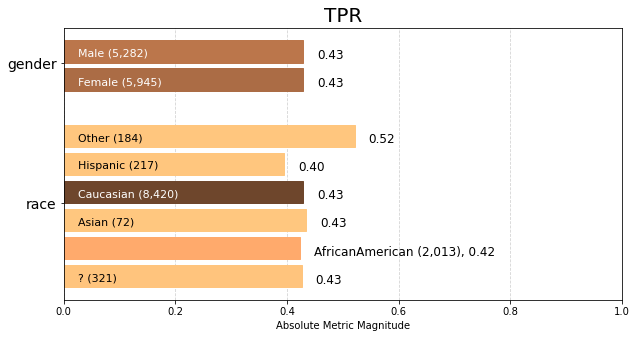

In [134]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
tpr = aqp.plot_group_metric(clean_xtab, 'tpr')

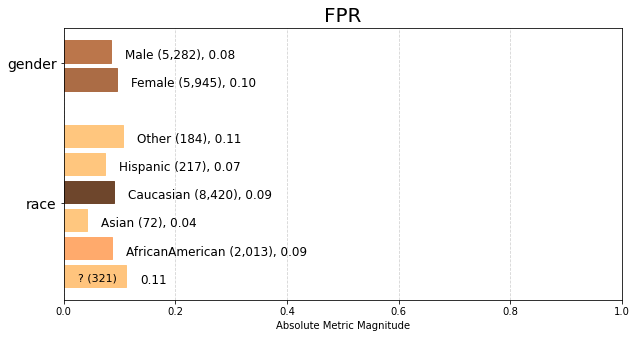

In [135]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr')

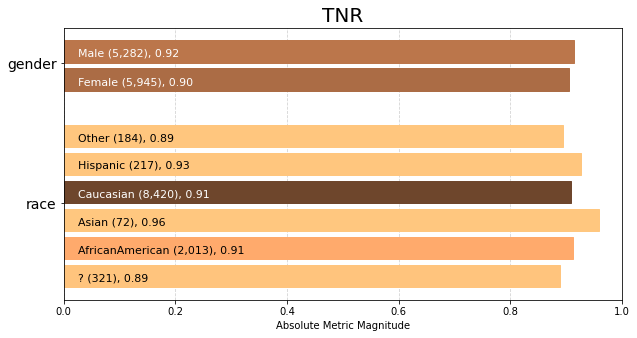

In [136]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

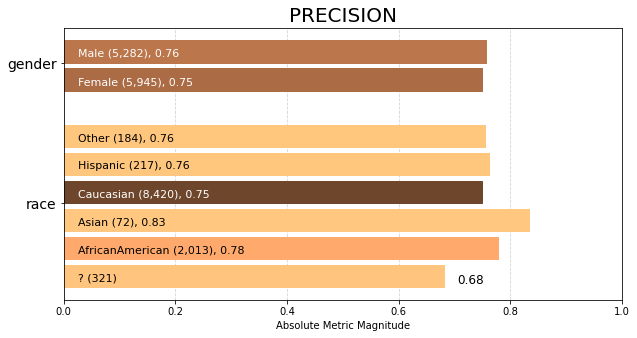

In [137]:
precision = aqp.plot_group_metric(clean_xtab, 'precision')

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

Responses >>
1. Based on below Fairnesss disparity chart for RACE(FPR Disparity RACE visual), Asian (FPR=0.45) have lowest chances of falsely selected for drug testing. 
1. Based on below Fairnesss disparity chart for RACE(TPR Disparity RACE visual), Asian (FPR=1.01) have slightly higher chances to positively selected for drug testing in comparison to Caucasian.
2. Based on below disparity chart(TPR) for Gender,  Women have almost same chances to get selected for patient drug testing. 
3. Based on below disparity chart (FPR) for Gender,  Women have higher chances to falsely selected for patient drug testing .


In [138]:
# Reference group fairness plot

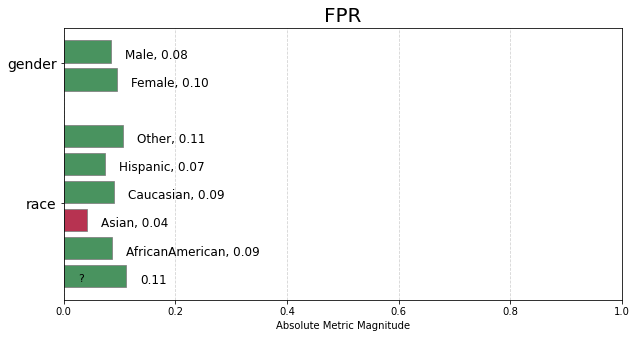

In [139]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

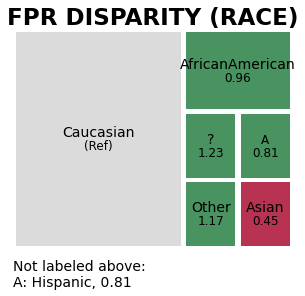

In [140]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='race')

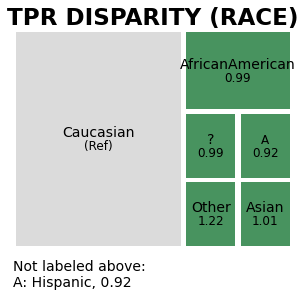

In [141]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='race')

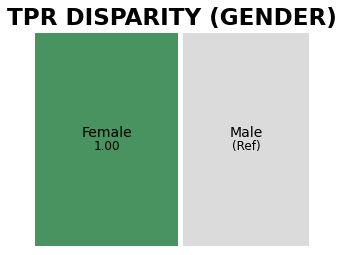

In [142]:
# Based on below disparity chart(TPR) for Gender,  Women have almost same chances to get selected for patient drug testing .
# Based on below disparity chart (FPR) for Gender,  Women have higher chances to falsely selected for patient drug testing .

tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='gender')

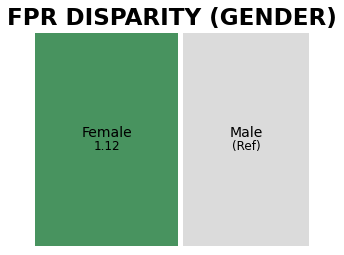

In [143]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='gender')